# Overview

The goal of this notebook is to show how you can use the tools in this package to perform ellipse fitting routines on images of galaxies (with or without bars), and potentially use these ellipse fits to determine various properties of the bar and disc.


### Background information

Jedrzejewski (1987) described an iterative method to construct a set of ellipses to fit the isophotes of a (barred) galaxy. This technique has since been used in numerous works, such as: Wozniak et al. (1995); Jogee et al. (2004); Erwin (2005); Menendez-Delmestre et al. (2007); Gadotti (2008); Aguerri et al. (2009); Li et al. (2011); Guo et al. (2023). Jedrzejewski's method has been implemented in the Photutils Python package (https://photutils.readthedocs.io/en/stable/index.html). It works great. However, one downside is that it is dependent on initial estimates of the semi-major axis, position angle and ellipticity. Different initial conditions can result in different final models. This is awkward, especially when you have a large sample and do not have reliable initial estimates. 

This problem is addressed here. We implement the Photutils routines in such a way that makes it independent of the initial estimates. These ellipse models can then be used to estimate various properties of a potential bar and/or disc (such as PA$_{\rm bar}$, L$_{\rm bar}$, $\epsilon_{\rm bar}$, PA$_{\rm disc}$, inc$_{\rm disc}$).

# Imports

In [12]:
import numpy as np
import photutils.isophote as phot
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import scipy.stats as stats

import sys
sys.path.append('../')
from barpy import *

# Step 0: Load data
The `barpy/tutorial/data/` directory contains a few example images. Let's load one. 

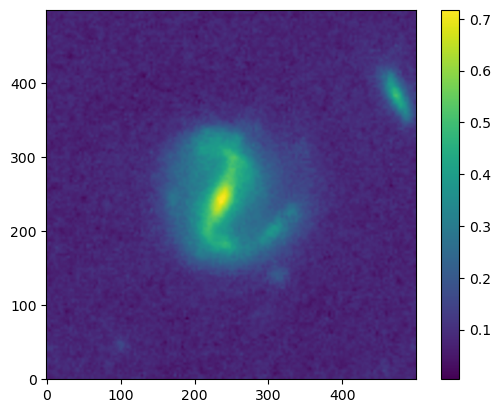

In [2]:
gal_img_loc = 'data/CEERS/88112350.png'

img = mpimg.imread(gal_img_loc)
img = img[:,:,0] #Take the first band

plt.imshow(img, origin='lower')
plt.colorbar()
plt.show()

# Step 1: Fitting ellipses

We will first demonstrate various ways to fit ellipse models using barpy. There are multiple modes; we recommend using `mode=4`. Fitting ellipes typically starts with loading a config object (`fit_ellipses_config()`) and adjusting any parameters you want to change from default. Then, you can run `fit_ellipses()`.

### Mode = 1
The first mode (`config.mode = 1`) corresponds to the basic functionality of Photutils. We need initial estimates for sma, eps, and pa. You can also pass estimates for x0 and y0. If these are not passes, it is assumed the centre of the image is the centre of the galaxy. The centre of the ellipses is fixed. It returns the optimal `photutils.isophote.isophote.IsophoteList` and `photutils.isophote.geometry.EllipseGeometry`. 

In [3]:
config = fit_ellipses_config()
config.mode = 1

isolist, _ = fit_ellipses(img, sma0 = 130, eps0 = 0.8, pa0 = 100, config = config)

Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 130.0000, eps0 = 0.8000, pa0 = 100.0000


You can use `plot_ellipse_results()` to quickly view the fitting results.

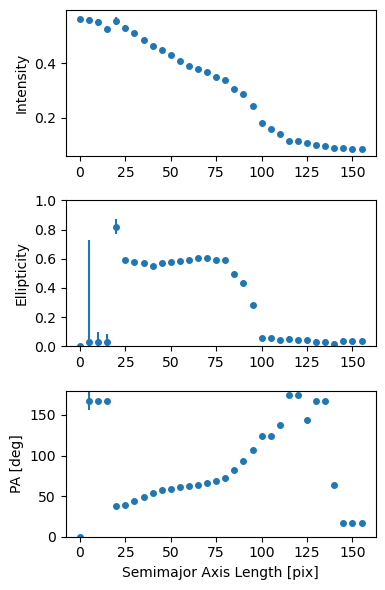

In [4]:
plot_ellipse_results(isolist)

### Mode = 2
The second mode (`config.mode = 2`) performs ellipse fitting in a two-step approach. It still needs initial conditions and runs the ellipse fitting algorithm, but the centre of the ellipses is not fixed. After the first iteration, we check what the updated eps and pa values are at sma0. We do this a number of times (`config.n_iter_converge`), or until the initial conditions converge. This generally results in more accurate fits than the previous mode. 

Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 100.0000, eps0 = 0.8000, pa0 = 100.0000
Iteration 0: x0 = 239.0060, y0 = 243.4353, sma0 = 100.0000, eps0 = 0.1955, pa0 = 112.1985
Iteration 1: x0 = 239.0181, y0 = 243.8055, sma0 = 100.0000, eps0 = 0.1863, pa0 = 113.8559
Iteration 2: x0 = 238.8089, y0 = 243.3811, sma0 = 100.0000, eps0 = 0.1860, pa0 = 113.9030


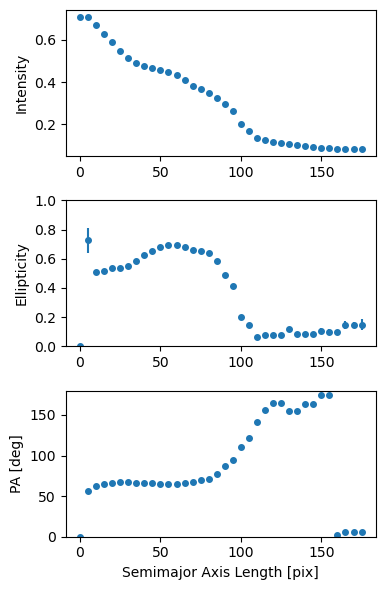

In [5]:
config = fit_ellipses_config()
config.mode = 2

isolist, _ = fit_ellipses(img, sma0 = 100, eps0 = 0.8, pa0 = 100, config = config)
plot_ellipse_results(isolist)

### Mode = 3

The third mode (`config.mode = 3`)only needs an initial estimate for sma0. It will randomly choose intial values for eps and pa at the user-defined sma0 and run `mode=2` for these randomised values. This is done a number of times (`config.n_iter`), and returns a list of `photutils.isophote.isophote.IsophoteList` and a list of `photutils.isophote.geometry.EllipseGeometry`. 

Round 0....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 100.0000, eps0 = 0.1877, pa0 = 83.7480
Iteration 0: x0 = 238.8204, y0 = 243.5995, sma0 = 100.0000, eps0 = 0.1868, pa0 = 113.7614
Iteration 1: x0 = 239.1360, y0 = 243.4861, sma0 = 100.0000, eps0 = 0.1860, pa0 = 113.8699

Round 1....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 100.0000, eps0 = 0.6158, pa0 = 89.0005
Iteration 0: x0 = 238.8089, y0 = 243.2536, sma0 = 100.0000, eps0 = 0.1953, pa0 = 112.9538
Iteration 1: x0 = 238.9074, y0 = 243.8025, sma0 = 100.0000, eps0 = 0.1866, pa0 = 113.8665
Iteration 2: x0 = 239.0060, y0 = 243.4678, sma0 = 100.0000, eps0 = 0.1861, pa0 = 113.8665

Round 2....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 100.0000, eps0 = 0.9282, pa0 = 77.2688
Iteration 0: x0 = 239.0727, y0 = 243.0233, sma0 = 100.0000, eps0 = 0.1978, pa0 = 111.8087
Iteration 1: x0 = 239.6506, y0 = 243.1557, sma0 = 100.0000, eps0 = 0.1878, pa0 = 113.7145
Iteration 2: x0 = 239.1401, y0 = 243.4640

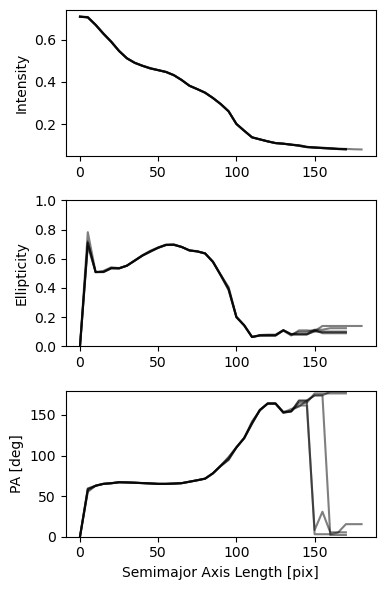

In [6]:
config = fit_ellipses_config()
config.mode = 3

isolists, _ = fit_ellipses(img, sma0 = 100, config = config)
plot_ellipse_results(isolists)

### Mode = 4
The fourth mode (`config.mode = 4`) is similar to the third mode. However, here we also randomly choose different values for sma, so no initial conditions are needed at all. This mode is preferred. Like the third mode, this will return a list of `photutils.isophote.isophote.IsophoteList` and a list of `photutils.isophote.geometry.EllipseGeometry`. Further functionality is provided to average or choose the best-fit `IsophoteList`.

Note that some randomised initial conditions are not able to result in any meaningful fit. This is expected, and these are automatically excluded from the output.

Round 0....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 155.0000, eps0 = 0.9994, pa0 = 62.0290
No solution found. Continuing.

Round 1....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 90.0000, eps0 = 0.9327, pa0 = 130.7598


/Users/tobias/miniconda3/envs/astro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tobias/miniconda3/envs/astro/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Iteration 0: x0 = 238.9261, y0 = 243.9705, sma0 = 90.0000, eps0 = 0.4679, pa0 = 87.3727
Iteration 1: x0 = 238.8248, y0 = 244.3450, sma0 = 90.0000, eps0 = 0.4678, pa0 = 87.4106

Round 2....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 120.0000, eps0 = 0.1241, pa0 = 110.3926
Iteration 0: x0 = 238.6195, y0 = 243.9744, sma0 = 120.0000, eps0 = 0.0493, pa0 = 140.6133
Iteration 1: x0 = 238.6195, y0 = 243.5505, sma0 = 120.0000, eps0 = 0.0497, pa0 = 140.6133

Round 3....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 155.0000, eps0 = 0.0497, pa0 = 156.1798
Iteration 0: x0 = 239.0393, y0 = 244.4439, sma0 = 155.0000, eps0 = 0.2012, pa0 = 3.8323
Iteration 1: x0 = 239.0726, y0 = 243.6374, sma0 = 155.0000, eps0 = 0.0667, pa0 = 3.8323
Iteration 2: x0 = 239.1872, y0 = 244.1442, sma0 = 155.0000, eps0 = 0.0667, pa0 = 3.8323

Round 4....
Starting conditions: x0 = 250.0000, y0 = 250.0000, sma0 = 85.0000, eps0 = 0.8208, pa0 = 79.3597
Iteration 0: x0 = 238.8250, y0 = 243.2529, sma0 =

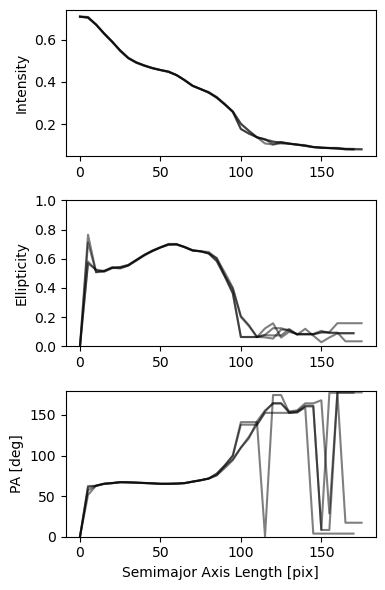

In [7]:
config = fit_ellipses_config()
config.mode = 4

isolists, _ = fit_ellipses(img, config = config)
plot_ellipse_results(isolists)

A list of `IsophoteList`'s can be averaged with `average_isolists()`, or the best-fit `IsophoteList` can be chosen with `select_best_isolist()`.

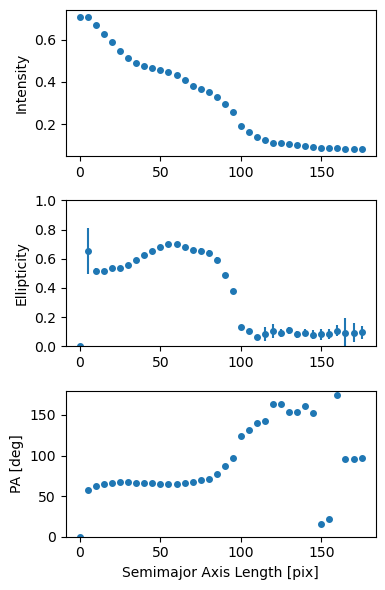

In [8]:
avg_isolist = average_isolists(isolists)
plot_ellipse_results(avg_isolist)

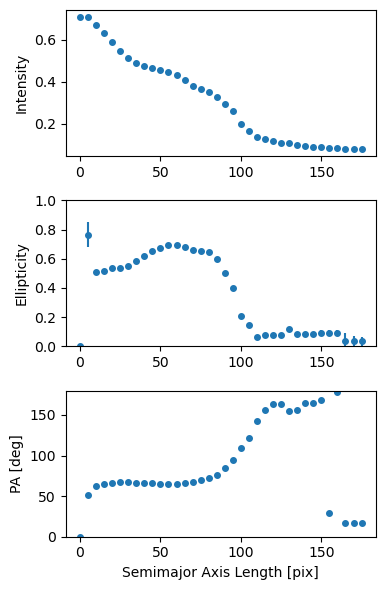

In [9]:
best_isolist = select_best_isolist(isolists, img)
plot_ellipse_results(best_isolist)

# Step 2: Derive bar and disc properties

The bar properties can be estimated from the ellipse fits using `find_bar_in_isophotes()`. The code works by finding bar signatures in the ellipse profiles. These include:

- The propsed bar must have a maximum ellipticity larger than `eps_threshold` (default 0.25).    
- The ellipses beyond the proposed bar must drop in ellipticity with a value of at least `eps_drop` (default 0.1).  
- The PA of the ellipses beyond the proposed bar must change with at least `pa_change` (default 10 degrees).  
- The PA of the ellipses inside the proposed bar must stay relatively constant, with a maximum allowed variation of `pa_variation` (default 40 degrees).   
- The edge of the proposed bar must be either at the maximum ellipiticty, or within `eps_max_flex` (default 0.1). 
- The middle ellipses are typically not well constrained, so the proposed bar should also be larger than `sma_min` (default 6). 

All of these parameters can be tuned. The ellipse with the largest sma that fullfills all of the above is selected as the ellipse that traces the edge of the bar. The `plot = True` and `img = img` are not necessary for the calculation of these parameters. They are used to create a helpful diagnostic plot. 

Note that, while ellipse fitting is a great, intuitive and easy-to-use tool to calculate these bar properties, it is sometimes hard to identify the correct ellipse that corresponds to the bar. This is especially true for weaker bars, or disturbed discs. It is highly recommended that you visually inspect the diagnostic plots and verify that it worked as intended. Some things to look out for:

- The ellipticity is higher within the bar than outside the bar.
- The ellipticity drops and PA changes just outside the bar.
- The PA stays constant inside the bar.
- The ellipse and PA visually corresponds to the bar.

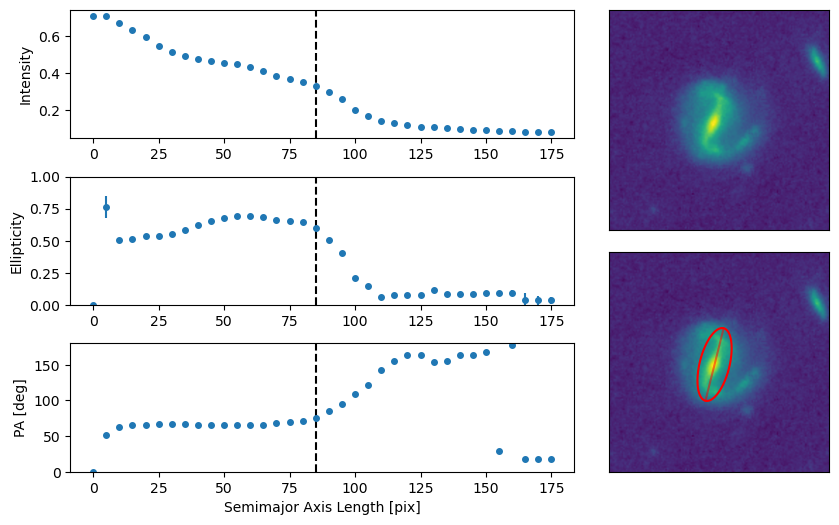

R_bar = 85.0 pix
eps_bar = 0.60
PA_bar = 75.90 deg


In [10]:
bar_sma, bar_eps, bar_pa = find_bar_in_isophotes(best_isolist, sma_min = 6, eps_threshold = 0.25, eps_drop = 0.1, 
                                                 eps_max_flex = 0.1, pa_change = 10, pa_variation = 40, 
                                                 plot = True, img = img)


print(f'R_bar = {bar_sma:.1f} pix')
print(f'eps_bar = {bar_eps:.2f}')
print(f'PA_bar = {bar_pa:.2f} deg')

The disc properties can be estimated with `find_disc_in_isophotes()`. The inner isophotes are typically not well constrained, or disturbed by various structures (e.g. a bar, spiral arms, ...). The disc properties (PA$_{\rm disc}$, eps$_{\rm disc}$) are estimated by averaging these values for all the isophotes larger than `sma_min`. If a bar is present, it is highly recommended to set `sma_min = bar_sma`, so that only isophotes outside the bar region are used. 

There is also a `buffer` (default 1.2) argument. We only use isophotes with sma > sma_min*buffer. 

As with the bar properties, it is important to inspect the diagnostic plots to make sure the code worked as intended and the returned parameters indeed correspond to the real disc properties. Some things to look out for:

- The Ellipticity and PA stays roughly constant outside the excluded region.
- The ellipse and PA visually correspond to the disc of the galaxy. 

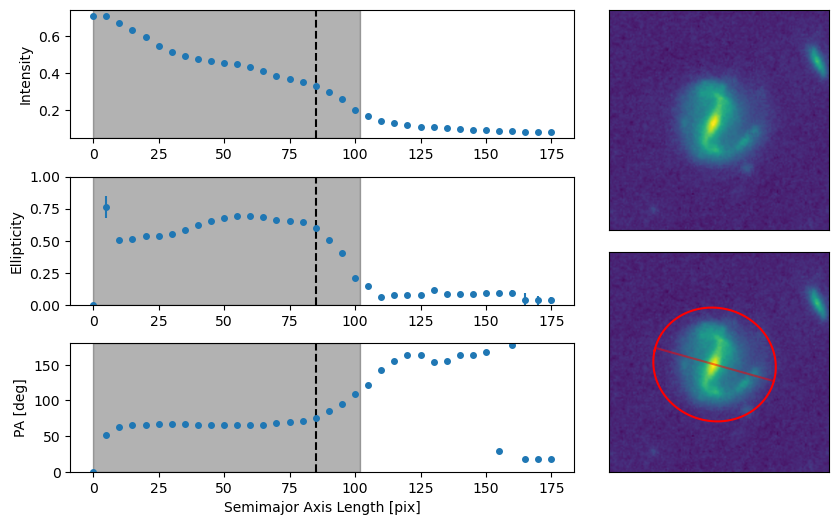

eps_disc = 0.08
PA_disc = 138.40 deg


In [43]:
disc_eps, disc_pa = find_disc_in_isophotes(best_isolist, sma_min = bar_sma, plot = True, img = img)

print(f'eps_disc = {disc_eps:.2f}')
print(f'PA_disc = {disc_pa:.2f} deg')

eps$_{\rm disc}$ can trivially be converted to inc$_{\rm disc}$ using:

$\cos(i) = 1 - \epsilon = b/a $  ,

where i is the inclination, $\epsilon$ is the ellipticity, $a$ is the minor axis, and $b$ is the major axis. However, this assumes a thin disc. Alternatively, one can use: 

$\cos^{2}(i) = \frac{q^2 - q_0^2}{1 - q_0^2}$,  
where $q$ the axis ratio ($q = b/a$), and $q_0$ the intrinsic oblateness of the galaxy. Typical values are $q_0 \approx 0.2 - 0.25$.

This can be done with `eps2inc()`, where the first method is used by default, and the second is used if q0 is defined. 

In [46]:
eps2inc(disc_eps), eps2inc(disc_eps, q0 = 0.2)

(22.97752028045061, 23.479420561608027)